In [73]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

import pandas as pd
import numpy as np

import sqlite3
import pandas as pd
import json

In [74]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [75]:
from io import StringIO
from html.parser import HTMLParser
from bs4 import BeautifulSoup

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def get_latex_from_alt(context):
    strip_deliminators = lambda latex: latex.replace('$','').replace('\\[','').replace('\\]','')

    context_soup = BeautifulSoup(context)
    latex_images = context_soup.find_all('img')
    for image in latex_images:
        image.replace_with(strip_deliminators(image['alt']))
    # return [strip_deliminators(image['alt']) for image in latex_images]
    return str(context_soup)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [76]:
get_latex_from_alt('<html><head></head><body><p>In the following list of numbers, the integer <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> appears <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> times in the list for <img alt=\"$1 \\leq n \\leq 200$\" class=\"latex\" height=\"15\" src=\"//latex.artofproblemsolving.com/9/1/7/917e3430450e9049864739d088103bef0598a899.png\" style=\"vertical-align: -2px\" width=\"95\"/>.<img alt=\"\\[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \\ldots, 200, 200, \\ldots , 200\\]\" class=\"latexcenter\" height=\"16\" src=\"//latex.artofproblemsolving.com/f/4/f/f4f50e6ad3c33b14e7352b50ecc5ff8322c37702.png\" width=\"332\"/>What is the median of the numbers in this list?\n</p><p>\n</p></body></html>')

'<html><head></head><body><p>In the following list of numbers, the integer n appears n times in the list for 1 \\leq n \\leq 200.1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \\ldots, 200, 200, \\ldots , 200What is the median of the numbers in this list?\n</p><p>\n</p></body></html>'

In [77]:
con = sqlite3.connect('site/amc10_problems.db')

cursor = con.cursor()
cursor.execute('SELECT * FROM problem')

problems_data = pd.DataFrame(cursor.fetchall(), columns=['id','test','number','choices','problem','answer','labels','difficulty'])

In [78]:
problems_data['test'] = problems_data['test'].apply(json.loads)
problems_data['year'] = problems_data['test'].apply(lambda x: str(x[0]))
problems_data['instance'] = problems_data['test'].apply(lambda x: x[2])

problems_data.head(5)

,id,test,number,choices,problem,answer,labels,difficulty,year,instance
0,1,"[2015, 10, A]",1,"[""\\ -125"", ""\\ -120"", ""\\ \\frac{1}{5}"", ""\\ ...",<html><head></head><body><p>What is the value ...,"""C""",None,1,2015,A
1,2,"[2015, 10, A]",2,"[""\\ 3"", ""\\ 5"", ""\\ 7"", ""\\ 9"", ""\\ 11""]",<html><head></head><body><p>A box contains a c...,"""D""",None,1,2015,A
2,3,"[2015, 10, A]",3,"[""\\ 9"", ""\\ 18"", ""\\ 20"", ""\\ 22"", ""\\ 24""]",<html><head></head><body><p>Ann made a <img al...,"""D""",None,1,2015,A
3,4,"[2015, 10, A]",4,"[""\\ \\frac{1}{12}"", ""\\ \\frac{1}{6}"", ""\\ \\...","<html><head></head><body><p>Pablo, Sofia, and ...","""B""",None,1,2015,A
4,5,"[2015, 10, A]",5,"[""\\ 81"", ""\\ 85"", ""\\ 91"", ""\\ 94"", ""\\ 95""]",<html><head></head><body><p>Mr. Patrick teache...,"""E""",None,1,2015,A


In [79]:
problems_data['year'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2021_Fall', '2022'], dtype=object)

In [80]:
problems_data = problems_data[problems_data['year'].isin(['2020', '2021_Fall', '2021', '2022'])]
problems_data.set_index('id')

,test,number,choices,problem,answer,labels,difficulty,year,instance
id,,,,,,,,,
244,"[2020, 10, A]",1,"[""\\ {-}\\frac{2}{3}"", ""\\ \\frac{7}{36}"", ""\\...",<html><head></head><body><p>What value of <img...,"""E""",None,1,2020,A
245,"[2020, 10, A]",2,"["" 0 "", "" 15 "", "" 30 "", "" 45 "", "" 60""]",<html><head></head><body><p>The numbers <img a...,"""C""",None,1,2020,A
246,"[2020, 10, A]",3,"["" {-}1 "", "" 1 "", "" \\frac{abc}{60} "", "" \\...",<html><head></head><body><p>Assuming <img alt=...,"""A""",None,1,2020,A
247,"[2020, 10, A]",4,"[""\\ 20"", ""\\ 22"", ""\\ 24"", ""\\ 25"", ""\\ 26""]",<html><head></head><body><p>A driver travels f...,"""E""",None,1,2020,A
248,"[2020, 10, A]",5,"["" 12 "", "" 15 "", "" 18 "", "" 21 "", "" 25""]",<html><head></head><body><p>What is the sum of...,"""C""",None,1,2020,A
...,...,...,...,...,...,...,...,...,...
438,"[2022, 10, B]",21,"[""\\ 10 "", ""\\ 13 "", ""\\ 19 "", ""\\ 20 "", ""\\ 23""]","<html><head></head><body><p>Let <img alt=""$P(x...","""E""",None,5,2022,B
439,"[2022, 10, B]",22,"[""~48\\pi"", ""~68\\pi"", ""~96\\pi"", ""~102\\pi"", ...","<html><head></head><body><p>Let <img alt=""$S$""...","""E""",None,5,2022,B
440,"[2022, 10, B]",23,"[""\\frac{1}{3} "", ""\\frac{1}{2} "", ""\\frac{2...",<html><head></head><body><p>Ant Amelia starts ...,"""C""",None,5,2022,B


In [81]:
labeled_data = pd.read_csv('problem_labels.csv').replace([True,False],[1,0])
labeled_data.shape

(200, 83)

In [82]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,Dice Problems,Card Problems,Placing/Picking/Labeling Problems,Stars and Bars,Expected Value,Recursive Counting,Conditional Probability,Complementary Counting,States,Principle of Inclusion-Exclusion
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020,10,B,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,2020,10,B,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,2020,10,B,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,2020,10,B,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
misc_labels = (6,22)
alg_labels = (23,43)
geo_labels = (44,61)
nt_labels = (62,69)
cb_labels = (69,82)

def extract_labels(cols):
    start, end = cols
    return labeled_data[labeled_data.columns[start:end]].values.tolist()

In [84]:
labeled_data['misc-labels'] = extract_labels(misc_labels)
labeled_data['alg-labels'] = extract_labels(alg_labels)
labeled_data['geo-labels'] = extract_labels(geo_labels)
labeled_data['nt-labels'] = extract_labels(nt_labels)
labeled_data['cb-labels'] = extract_labels(cb_labels)

labeled_data['Miscellaneous'] = labeled_data['misc-labels'].apply(lambda x: int(any(x)))
labeled_data['Combinatorics'] = labeled_data['cb-labels'].apply(lambda x: int(any(x)))

In [85]:
labeled_data['tl-labels'] = labeled_data[['Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics']].values.tolist()

labeled_data = labeled_data[['Year','Instance','Problem',
                             'Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics',
                             'misc-labels','alg-labels','geo-labels','nt-labels','cb-labels','tl-labels',]]
labeled_data

,Year,Instance,Problem,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2022,A,1,1,1,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"
1,2022,A,2,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
2,2022,A,3,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
3,2022,A,4,1,1,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"
4,2022,A,5,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020,B,21,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
196,2020,B,22,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
197,2020,B,23,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
198,2020,B,24,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"


In [86]:
problems_data = problems_data[['year','instance','number','choices','problem']]
problems_data['problem'] = problems_data['problem'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['choices'] = problems_data['choices'].map(lambda x: ' '.join(json.loads(x)))
problems_data['context'] = problems_data['problem'] + problems_data['choices']
problems_data.drop(columns=['problem','choices'],inplace=True)
labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_10679/3010592191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)


In [87]:
problems_data = problems_data.merge(right=labeled_data,on=['year','instance','number'])
problems_data

,year,instance,number,context,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2020,A,1,What value of x satisfies\nx- \frac{3}{4} = \f...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
1,2020,A,2,"The numbers 3, 5, 7, a, and b have an average ...",1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"
2,2020,A,3,"Assuming a\neq3, b\neq4, and c\neq5, what is t...",0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
3,2020,A,4,A driver travels for 2 hours at 60 miles per h...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
4,2020,A,5,What is the sum of all real numbers x for whic...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2022,B,21,Let P(x) be a polynomial with rational coeffic...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]"
195,2022,B,22,Let S be the set of circles in the coordinate ...,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
196,2022,B,23,Ant Amelia starts on the number line at 0 and ...,1,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 1]"
197,2022,B,24,Consider functions f that satisfy |f(x)-f(y)|\...,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0]"


In [88]:
problems_data['context'].iloc[0]

'What value of x satisfies\nx- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}?\n\n\\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}'

In [89]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-05

In [90]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',truncation_side='left',truncation=True)
tokenizer.add_tokens(list(open('latex-vocabulary/latex_symbols.txt','r')))

13855

In [91]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['context']
        self.targets = dataframe[labels]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [92]:
train_size = 0.8
training_data = problems_data.sample(frac=train_size, random_state=200).reset_index(drop=True)
validation_data = problems_data.drop(training_data.index).reset_index(drop=True)

In [93]:
training_dataset = MultiLabelDataset(training_data, tokenizer, 'tl-labels', MAX_LEN)
val_dataset = MultiLabelDataset(validation_data, tokenizer, 'tl-labels', MAX_LEN)

In [94]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_dataset, **train_params)
testing_loader = DataLoader(val_dataset, **test_params)

In [95]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        return self.classifier(pooler)

In [96]:
top_level_model = DistilBERTClass(num_classes=5)
top_level_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [97]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [98]:
optimizer = torch.optim.Adam(params =  top_level_model.parameters(), lr=LEARNING_RATE)

In [99]:
class ModelTraining:
    def __init__(self, model, training_loader, testing_loader, optimizer):
        self.model = model
        self.training_loader = training_loader
        self.optimizer = optimizer
        self.testing_loader = testing_loader
    
    def train_model(self,epoch):
        self.model.train()
        for _, data in enumerate(self.training_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = self.model(ids, mask)

            self.optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if _%1000==0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def validation(self):
        self.model.eval()
        fin_targets=[]
        fin_outputs=[]
        with torch.no_grad():
            for _, data in enumerate(self.testing_loader):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = self.model(ids, mask)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        return fin_outputs, fin_targets

In [118]:
model_trainer = ModelTraining(top_level_model,training_loader,testing_loader,optimizer)
for epoch in range(20):
    model_trainer.train_model(epoch)

Epoch: 0, Loss: 0.13363157212734222
Epoch: 1, Loss: 0.09501349925994873
Epoch: 2, Loss: 0.06987176090478897
Epoch: 3, Loss: 0.10805416852235794
Epoch: 4, Loss: 0.06403560936450958
Epoch: 5, Loss: 0.06444812566041946
Epoch: 6, Loss: 0.07929712533950806
Epoch: 7, Loss: 0.08253901451826096
Epoch: 8, Loss: 0.07706640660762787
Epoch: 9, Loss: 0.05165286362171173
Epoch: 10, Loss: 0.035854700952768326


KeyboardInterrupt: 

In [122]:
# torch.save(top_level_model,'top-level-distilbert-amc10-2020-2022.pt')

In [120]:
# model = torch.load('top-level-distilbert-amc10-2020-2022.pt')

In [103]:
# def validation(testing_loader):
#     model.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     with torch.no_grad():
#         for _, data in enumerate(testing_loader):
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.float)
#             outputs = top_level_model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
#     return fin_outputs, fin_targets

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 0.85
F1 Score (Micro) = 0.9090909090909092
F1 Score (Macro) = 0.9031372549019607


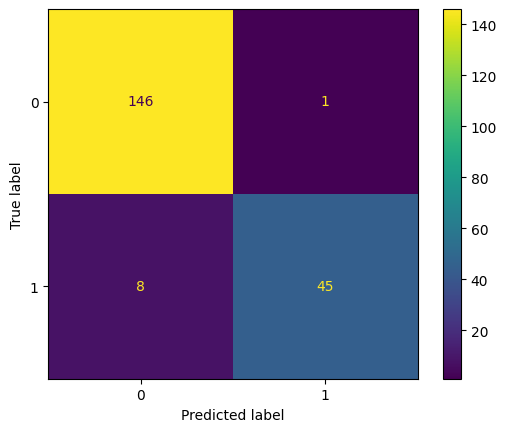

In [123]:
from itertools import chain

outputs, targets = model_trainer.validation()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [105]:
# for cm in metrics.multilabel_confusion_matrix(targets,outputs):
#     matrix = metrics.ConfusionMatrixDisplay(cm)
#     matrix.plot()
# single_label_accuracy = metrics.accuracy_score(list(chain.from_iterable(targets)), list(chain.from_iterable(outputs)))
# print(f"Single-label Accuracy Score = {single_label_accuracy}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


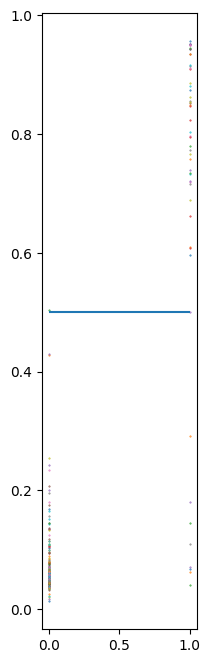

In [106]:
outputs, targets = model_trainer.validation()
import matplotlib.pyplot as plt

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

In [107]:
def generate_model(dataframe, labels):
    training_data = dataframe.sample(frac=train_size, random_state=200).reset_index(drop=True)
    validation_data = dataframe.drop(training_data.index).reset_index(drop=True)

    training_dataset = MultiLabelDataset(training_data, tokenizer, labels, MAX_LEN)
    val_dataset = MultiLabelDataset(validation_data, tokenizer, labels, MAX_LEN)

    training_loader = DataLoader(training_dataset, **train_params)
    testing_loader = DataLoader(val_dataset, **test_params)

    model = DistilBERTClass(len(dataframe[labels].iloc[0]))
    model.to(device)

    return model, training_loader, testing_loader

In [108]:
alg_data = problems_data.loc[problems_data['Algebra'] == True]
alg_data = alg_data[['year','instance','number','context','alg-labels']].reset_index()

In [109]:
alg_model, alg_training_loader, alg_testing_loader = generate_model(alg_data, 'alg-labels')
alg_optimizer = torch.optim.Adam(params=alg_model.parameters(), lr=LEARNING_RATE)
model_trainer = ModelTraining(alg_model, alg_training_loader, alg_testing_loader, alg_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [110]:
for epoch in range(40):
    model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.6909871101379395
Epoch: 1, Loss: 0.6269580125808716
Epoch: 2, Loss: 0.5621591210365295
Epoch: 3, Loss: 0.5240626931190491
Epoch: 4, Loss: 0.48644155263900757
Epoch: 5, Loss: 0.4590255618095398
Epoch: 6, Loss: 0.4101589620113373
Epoch: 7, Loss: 0.4150256812572479
Epoch: 8, Loss: 0.41459640860557556
Epoch: 9, Loss: 0.37792059779167175
Epoch: 10, Loss: 0.37865397334098816
Epoch: 11, Loss: 0.3241423964500427
Epoch: 12, Loss: 0.30993950366973877
Epoch: 13, Loss: 0.31268617510795593
Epoch: 14, Loss: 0.33772844076156616
Epoch: 15, Loss: 0.3068476617336273
Epoch: 16, Loss: 0.31159117817878723
Epoch: 17, Loss: 0.2745603322982788
Epoch: 18, Loss: 0.2681272327899933
Epoch: 19, Loss: 0.27998849749565125
Epoch: 20, Loss: 0.25260302424430847
Epoch: 21, Loss: 0.2439039647579193
Epoch: 22, Loss: 0.24355407059192657
Epoch: 23, Loss: 0.24296095967292786
Epoch: 24, Loss: 0.29061758518218994
Epoch: 25, Loss: 0.2338138371706009
Epoch: 26, Loss: 0.28710922598838806
Epoch: 27, Loss: 0.21244

Accuracy Score = 0.0
F1 Score (Micro) = 0.0
F1 Score (Macro) = 0.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


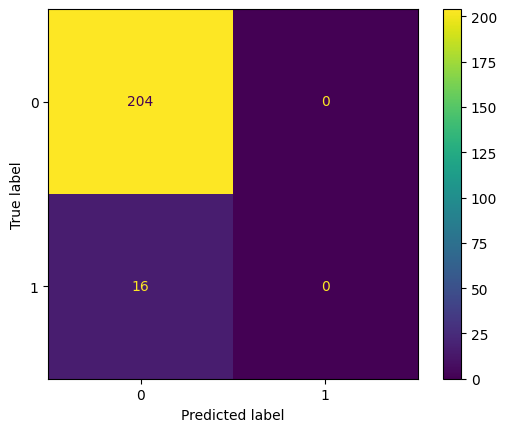

In [111]:
outputs, targets = model_trainer.validation()
outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [112]:
geo_data = problems_data.loc[problems_data['Geometry'] == True]
geo_data = geo_data[['year','instance','number','context','geo-labels']].reset_index()
geo_data

,index,year,instance,number,context,geo-labels
0,9,2020,A,10,"Seven cubes, whose volumes are 1, 8, 27, 64, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,11,2020,A,12,Triangle AMC is isosceles with AM = AC. Median...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,15,2020,A,16,A point is chosen at random within the square ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
3,19,2020,A,20,Quadrilateral ABCD satisfies \angle ABC = \ang...,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
4,22,2020,A,23,Let T be the triangle in the coordinate plane ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
5,26,2020,B,2,"Carl has 5 cubes each having side length 1, an...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,28,2020,B,4,The acute angles of a right triangle are a^{\c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,32,2020,B,8,Points P and Q lie in a plane with PQ=8. How m...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
8,34,2020,B,10,A three-quarter sector of a circle of radius 4...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
9,37,2020,B,13,Andy the Ant lives on a coordinate plane and i...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [113]:
geo_model, geo_training_loader, geo_testing_loader = generate_model(geo_data, 'geo-labels')
geo_optimizer = torch.optim.Adam(params=geo_model.parameters(), lr=LEARNING_RATE)
model_trainer = ModelTraining(geo_model, geo_training_loader, geo_testing_loader, geo_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [114]:
for epoch in range(40):
    model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.7046226263046265
Epoch: 1, Loss: 0.6544885039329529
Epoch: 2, Loss: 0.6083865165710449
Epoch: 3, Loss: 0.5533186197280884
Epoch: 4, Loss: 0.5269289016723633
Epoch: 5, Loss: 0.47164252400398254
Epoch: 6, Loss: 0.4895921051502228
Epoch: 7, Loss: 0.4296976923942566
Epoch: 8, Loss: 0.46262383460998535
Epoch: 9, Loss: 0.4176830053329468
Epoch: 10, Loss: 0.41834521293640137
Epoch: 11, Loss: 0.3882180452346802
Epoch: 12, Loss: 0.42116376757621765
Epoch: 13, Loss: 0.37540391087532043
Epoch: 14, Loss: 0.3789578974246979
Epoch: 15, Loss: 0.39577168226242065
Epoch: 16, Loss: 0.3223399221897125
Epoch: 17, Loss: 0.35392627120018005
Epoch: 18, Loss: 0.3627915680408478
Epoch: 19, Loss: 0.30718931555747986
Epoch: 20, Loss: 0.36029449105262756
Epoch: 21, Loss: 0.33752432465553284
Epoch: 22, Loss: 0.3115984797477722
Epoch: 23, Loss: 0.3096366822719574
Epoch: 24, Loss: 0.32371798157691956
Epoch: 25, Loss: 0.30964937806129456
Epoch: 26, Loss: 0.3097888231277466
Epoch: 27, Loss: 0.2739839

Accuracy Score = 0.2727272727272727
F1 Score (Micro) = 0.6666666666666666
F1 Score (Macro) = 0.24509803921568624


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


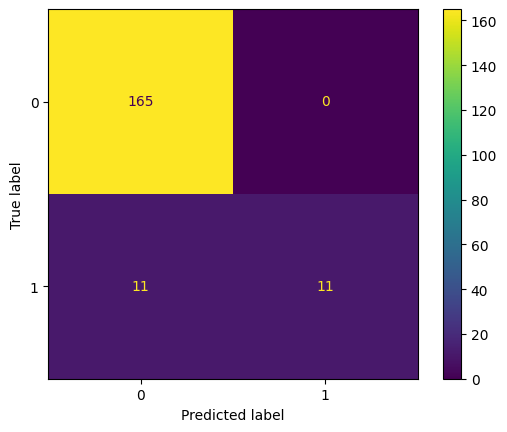

In [115]:
outputs, targets = model_trainer.validation()
outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


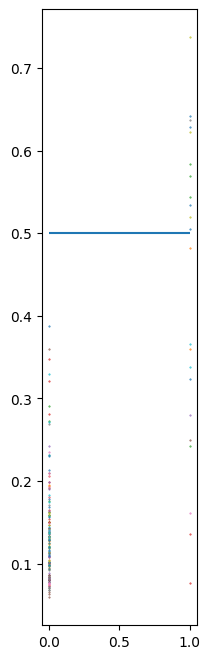

In [116]:
outputs, targets = model_trainer.validation()
import matplotlib.pyplot as plt

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()